In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sqlalchemy import create_engine

from src.data_preprocessing import align_feature_names
from src.scoring import generate_pd, apply_threshold
from src.portfolio_logic import create_risk_bucket
from src.evaluation import find_optimal_threshold

In [ ]:
model = joblib.load("../outputs/model/best_model.pkl")

engine = create_engine(
    "postgresql+psycopg2://<username>:<password>@localhost:5432/<database_name>"
)

df = pd.read_sql("SELECT * FROM lending_club_clean", engine)

In [3]:
df = align_feature_names(df)

In [4]:
feature_order = model.feature_names_in_
X = df[feature_order]

df["pd_score"] = generate_pd(model, X)
df["pd_score"].describe()

count    3.960300e+05
mean     1.961193e-01
std      1.192695e-01
min      1.368691e-13
25%      1.083647e-01
50%      1.666592e-01
75%      2.532031e-01
max      1.000000e+00
Name: pd_score, dtype: float64

In [5]:
optimal_threshold = find_optimal_threshold(
    df["default_flag"],
    df["pd_score"]
)

print("Optimal Threshold:", optimal_threshold)

Optimal Threshold: 0.18780880113941018


In [6]:
thresholds = np.arange(0.05, 0.51, 0.05)

thresholds_extended = list(thresholds) + [optimal_threshold]

results = []

for t in sorted(set(thresholds_extended)):
    
    df["temp_decision"] = df["pd_score"].apply(
        lambda x: "Reject" if x >= t else "Approve"
    )
    
    approval_rate = (df["temp_decision"] == "Approve").mean()
    
    approved_df = df[df["temp_decision"] == "Approve"]
    
    if len(approved_df) > 0:
        default_rate_approved = approved_df["default_flag"].mean()
    else:
        default_rate_approved = np.nan
    
    results.append({
        "Threshold": round(t, 4),
        "Approval_Rate": approval_rate,
        "Default_Rate_Approved": default_rate_approved
    })

simulation_df = pd.DataFrame(results).sort_values("Threshold")

simulation_df

,Threshold,Approval_Rate,Default_Rate_Approved
0,0.0500,0.028061,0.035364
1,0.1000,0.212176,0.065609
2,0.1500,0.433311,0.094374
3,0.1878,0.575681,0.113042
4,0.2000,0.615024,0.118858
5,0.2500,0.743201,0.139079
6,0.3000,0.829558,0.154071
7,0.3500,0.887241,0.165675
8,0.4000,0.926364,0.174619
9,0.4500,0.953622,0.181551


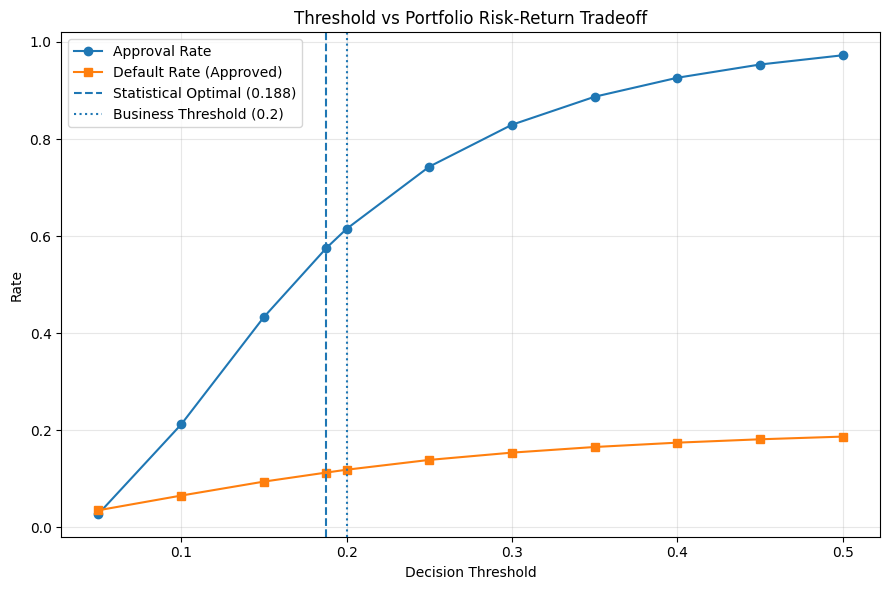

In [7]:
plt.figure(figsize=(9,6))

# Main curves
plt.plot(
    simulation_df["Threshold"],
    simulation_df["Approval_Rate"],
    marker="o",
    label="Approval Rate"
)

plt.plot(
    simulation_df["Threshold"],
    simulation_df["Default_Rate_Approved"],
    marker="s",
    label="Default Rate (Approved)"
)

# Mark optimal statistical threshold
plt.axvline(
    x=optimal_threshold,
    linestyle="--",
    label=f"Statistical Optimal ({optimal_threshold:.3f})"
)

# OPTIONAL: mark chosen business threshold (e.g. 0.20)
chosen_threshold = 0.20

plt.axvline(
    x=chosen_threshold,
    linestyle=":",
    label=f"Business Threshold ({chosen_threshold})"
)

plt.xlabel("Decision Threshold")
plt.ylabel("Rate")
plt.title("Threshold vs Portfolio Risk-Return Tradeoff")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

##### **Decision Threshold Selection**

The decision threshold was determined through a portfolio risk–growth trade-off analysis rather than relying solely on statistical optimality.

While the statistically optimal threshold (Youden Index) was **0.1878**, the final threshold was set at **0.20** because:

- It provides a higher approval rate compared to more conservative thresholds (e.g., 0.15).
- The increase in approved default rate from 0.1878 to 0.20 is relatively small.
- Beyond 0.20, the marginal increase in approval is accompanied by a more noticeable rise in default risk.

Thus, **0.20 represents a balanced and practical decision point between portfolio growth and risk containment.**

In [8]:
# Final business decision threshold
final_threshold = 0.20

df["decision"] = apply_threshold(
    df["pd_score"],
    final_threshold
)

print(f"Final Decision Threshold: {final_threshold}")

Final Decision Threshold: 0.2


In [9]:
df["risk_bucket"] = create_risk_bucket(df["pd_score"])

In [10]:
print("Decision Distribution:")
print(df["decision"].value_counts(normalize=True))

print("\nDefault Rate by Decision:")
print(df.groupby("decision")["default_flag"].mean())

print("\nDefault Rate by Risk Bucket:")
print(df.groupby("risk_bucket", observed=False)["default_flag"].mean())

Decision Distribution:
decision
Approve    0.615024
Reject     0.384976
Name: proportion, dtype: float64

Default Rate by Decision:
decision
Approve    0.118858
Reject     0.319575
Name: default_flag, dtype: float64

Default Rate by Risk Bucket:
risk_bucket
Low Risk       0.090422
Medium Risk    0.186964
High Risk      0.346236
Name: default_flag, dtype: float64


In [11]:
df_scoring = df[["loan_id", "pd_score", "decision", "risk_bucket"]]

df_scoring.to_sql(
    "fact_scoring",
    engine,
    if_exists="append",
    index=False
)

print("Scoring inserted successfully.")

Scoring inserted successfully.


In [12]:
# Save scored dataset as artifact
df.to_csv("../data/processed/lending_club_scored.csv", index=False)
df_scoring.to_csv("../data/processed/lending_club_scoring_table.csv", index=False)